<a href="https://colab.research.google.com/github/aulia-adil/craiglist-sales/blob/dewa/Proyek_Akhir_KASDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rumusan masalah

1. **Dataset Craiglist Sales (DCS) ini apa sih?** DCS adalah dataset terkait mobil second yang dijual oleh Perusahaan Craiglist. Tentunya dataset tersebut juga disertai dengan data-data relevan terkait penjualan mobil second tersebut.
1. **(Optional) Mengapa DCS dibuat?**
1. **(Optional) Bagaimana DCS dibuat?**
1. **(Optional) Apakah DCS akurat?**
1. **Apa karakteristik DCS?**
1. **Apa definisi dari setiap atribut DCS?**
1. **Masalah-masalah apa saja yang dimiliki DCS?**
1. **Mengapa masalah-masalah tersebut muncul?**
1. **Apa solusi dari setiap masalah yang dimiliki DCS?**
1. **Apakah ada independent variable dari DCS? Jika iya apa saja?**
1. **Apakah ada dependent variable dari DCS? Jika iya apa saja dan bagaimana korelasi hubungannya?**
1. **Bagaimana cara visualisasi dari setiap atribut yang ada pada DCS?**
1. **Apa makna dari setiap distribusi yang dimiliki atribut-atribut DCS? Apakah ada anomali di dalamnya?**
1. **(Optional) Apakah DCS dapat dikaitkan dengan dataset lain?**
1. **Apa yang bisa kita dapatkan dari DCS ini?**

## Import Module dan Dataset

In [1]:
# Library Adil nanti dibersihin aja
# import library
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as scp
import statsmodels.api as sm
import sys
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as scp
import statsmodels.api as sm
import sklearn.manifold as smn
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, RobustScaler
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as scp

In [3]:
def download_from_gdrive(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [4]:
# import cell
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Colab harus menggunakan akun UI untuk bisa mendownload file ini
download_from_gdrive('1BpEsEOQyd9F7m4TC7oGfu6e0wKtHV7gj')

In [6]:
!unzip -o 'archive.zip'

Archive:  archive.zip
  inflating: vehicles.csv            


In [7]:
# Read dataset
data = pd.read_csv("vehicles.csv")

## Exploratory Data Analysis dan Preprocessing Raw Data

Pertanyaan EDA Raw:

1. Apakah setiap atribut numerik bertipe numerik?
1. Apakah setiap atribut kategorik bertipe kategorik?
1. Berapa banyak persentase missing values setiap atribut?
1. Apakah ada row duplikat?
1. Apakah ada outlier?

In [8]:
#@title Fungsi
def see_dataset_dimension(data):
  print("Dimension")
  print("Row:", data.shape[0])
  print("Column:", data.shape[1])

def see_numerical_attribute(data):
  num_attr = data.select_dtypes(include=[np.number])
  print("Numerical Attribute")
  i = 1
  for column in num_attr.columns:
    print(str(i) + ".", column)
    i += 1

def see_categorical_attribute(data):
  cat_attr = data.select_dtypes(exclude=[np.number])
  print("Categorical Attribute")
  i = 1
  for column in cat_attr.columns:
    print(str(i) + ".", column)
    i += 1

def count_outlier_column(data, column):
  q1 = data.quantile(q=0.25)[column]
  q3 = data.quantile(q=0.75)[column]
  iqr = q3-q1
  upper_bound = q3 + iqr * 1.5
  lower_bound = q1 - iqr * 1.5
  upper_outliers = data.loc[data[column] > upper_bound, [column]]
  lower_outliers = data.loc[data[column] < lower_bound, [column]]
  return len(upper_outliers) + len(lower_outliers)

def numeric_descriptive_statistic(df):
  df = df.select_dtypes(include=[np.number])
  desc_stat = df.describe()
  columns = df.columns
  mode_list = []
  variance_list = []
  range_list = []
  skewness_list = []
  outlier_list = []
  for column in columns:
    outlier_list.append(count_outlier_column(df, column))
    skewness_list.append(df[column].skew())
    range = desc_stat[column]["max"]-desc_stat[column]["min"]
    range_list.append(range)
    variance = desc_stat[column]["std"] ** 2
    variance_list.append(variance)
    mode_list.append(scp.mode(df[column])[0][0])
  desc_stat.loc["mode"] = mode_list
  desc_stat.loc["variance"] = variance_list
  desc_stat.loc["range"] = range_list
  desc_stat.loc["skewness"] = skewness_list
  desc_stat.loc["total outlier"] = outlier_list
  return desc_stat

def numeric_cleaning_fillna_mean(df):
  df_res = df.select_dtypes(include=[np.number])
  columns = df_res.columns
  for column in columns:
    mean = df_res[column].mean()
    df_res[column].fillna(value=mean, inplace=True)
  return df_res

# Cek missing value
def cek_null(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df)
    
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data[missing_data['Total'] > 0])

In [9]:
print("Dimensi")
print("Baris:", data.shape[0])
print("Kolom:", data.shape[1])

print()
num_attr = data.select_dtypes(include=[np.number])
print("Atribut numerik")
i = 1
for column in num_attr.columns:
  print(str(i) + ".", column)
  i += 1

print("\nAtribut kategorik")
cat_attr = data.select_dtypes(exclude=[np.number])
i = 1
for column in cat_attr.columns:
  print(str(i) + ".", column)
  i += 1

print("\nDescriptive Statistic Numerical Attribute")
num_desc_stat = numeric_descriptive_statistic(data)
display(num_desc_stat)

print("\nDescriptive Statistic Categorical Attribute")
display(cat_attr.describe())

print("\nLihat persentase missing values")
display(cek_null(data))

print("\nHitung duplikasi data")
no_dup = data.drop_duplicates(inplace=False)
print("Jumlah duplikasi data:", len(data) - len(no_dup))

print("\nHitung outlier")
display(pd.DataFrame(num_desc_stat.loc['total outlier']))

Dimensi
Baris: 426880
Kolom: 26

Atribut numerik
1. id
2. price
3. year
4. odometer
5. county
6. lat
7. long

Atribut kategorik
1. url
2. region
3. region_url
4. manufacturer
5. model
6. condition
7. cylinders
8. fuel
9. title_status
10. transmission
11. VIN
12. drive
13. size
14. type
15. paint_color
16. image_url
17. description
18. state
19. posting_date

Descriptive Statistic Numerical Attribute


,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502
mode,7.207408e+09,0.000000e+00,2017.000000,1.000000e+05,NaN,33.779214,-84.411811
variance,2.000925e+13,1.484080e+14,89.342565,4.574530e+10,NaN,34.123514,337.290210



Descriptive Statistic Categorical Attribute


,url,region,region_url,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,posting_date
count,426880,426880,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426812,426810,426880,426812
unique,426880,404,413,42,29667,6,8,5,6,3,118264,3,4,13,12,241899,360911,51,381536
top,https://buffalo.craigslist.org/ctd/d/tonawanda...,columbus,https://spokane.craigslist.org,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,https://images.craigslist.org/00N0N_1xMPvfxRAI...,35 VEHICLES PRICED UNDER $3000!!! BIG TIME! T...,ca,2021-04-23T22:13:05-0400
freq,1,3608,2988,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,7357,231,50614,12



Lihat persentase missing values
               Total   Percent
county        426880  1.000000
size          306361  0.717675
cylinders     177678  0.416225
condition     174104  0.407852
VIN           161042  0.377254
drive         130567  0.305863
paint_color   130203  0.305011
type           92858  0.217527
manufacturer   17646  0.041337
title_status    8242  0.019308
long            6549  0.015342
lat             6549  0.015342
model           5277  0.012362
odometer        4400  0.010307
fuel            3013  0.007058
transmission    2556  0.005988
year            1205  0.002823
description       70  0.000164
posting_date      68  0.000159
image_url         68  0.000159


None


Hitung duplikasi data
Jumlah duplikasi data: 0

Hitung outlier


,total outlier
id,44.0
price,8177.0
year,15896.0
odometer,4385.0
county,0.0
lat,6413.0
long,195.0


In [10]:
print("Atribut drive dan cylinders terlihat numerik")
print()
print("Atribut drive")
display(cat_attr['drive'].dropna())
print()
print("Atribute cylinders")
display(cat_attr['cylinders'].dropna())

Atribut drive dan cylinders terlihat numerik

Atribut drive


31        rwd
32        4wd
33        4wd
34        4wd
35        4wd
         ... 
426874    rwd
426875    fwd
426876    fwd
426878    fwd
426879    rwd
Name: drive, Length: 296313, dtype: object


Atribute cylinders


27        8 cylinders
28        8 cylinders
29        8 cylinders
30        8 cylinders
31        6 cylinders
             ...     
426866    8 cylinders
426868    6 cylinders
426874    6 cylinders
426875    6 cylinders
426878    6 cylinders
Name: cylinders, Length: 249202, dtype: object

#### Identifikasi masalah dataset

1. Atribut `cylinders` disebut atribut kategorik tetapi sebenarnya mirip dengan atribut numerik.
1. Atribut `county` semuanya null values.
1. Atribut `size` hingga `paint color` memiliki banyak missing values.
1. Banyak outlier pada atribut numerik, hal ini perlu di visualisasi persebarannya.

In [11]:
cleaned_data = data.copy()
# Drop kolom county
cleaned_data.drop(columns = ['county'], inplace = True)

#### Visualisasi banyak iklan yang diposting setiap state

State yang paling banyak memposting iklan adalah CA


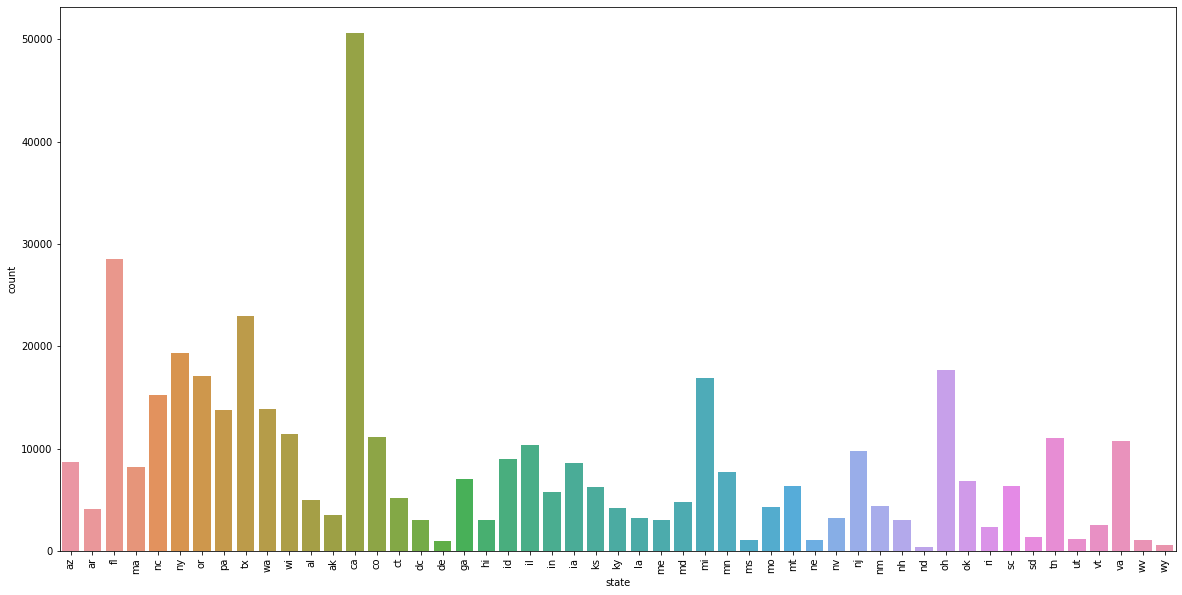

In [12]:
print("State yang paling banyak memposting iklan adalah CA")
plt.figure(figsize = (20, 10))
sns.countplot(x = 'state', data = data)
plt.xlabel("state")
plt.xticks(rotation = "vertical")
plt.show()

#### Visualisasi jumlah nilai odometer untuk setiap state

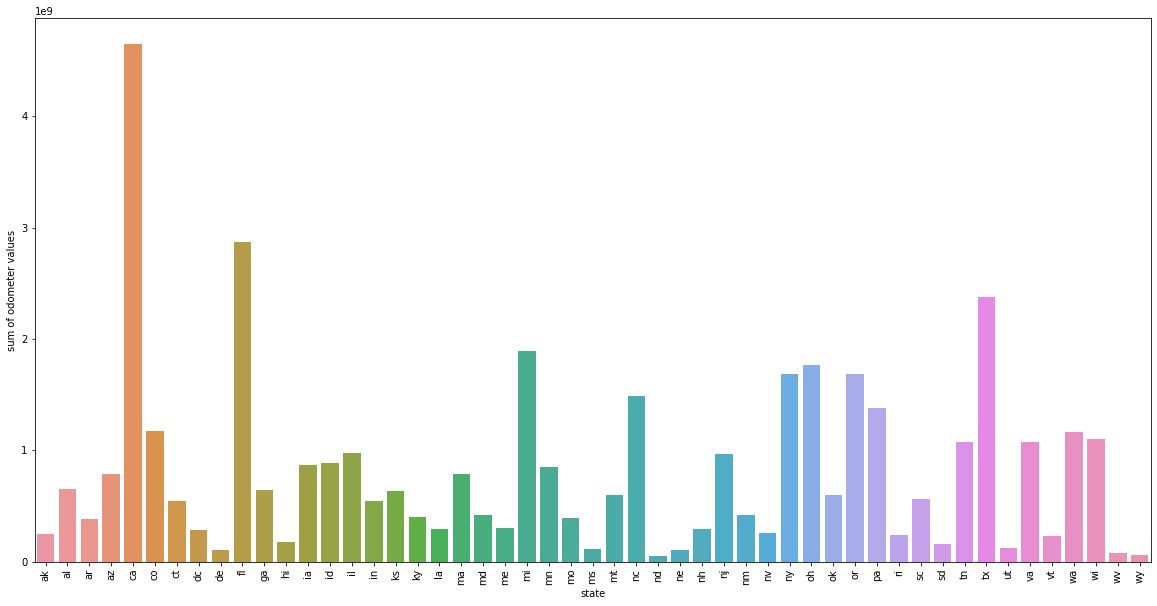

State yang paling sering menggunakan mobil adalah CA


In [13]:
# (Hint di soal disuruh pake year sama odometer, tapi menurutku odometer cukup)
state_odo = cleaned_data.loc[:, ['state', 'odometer']]
state_odo = state_odo.groupby('state', as_index = False).sum()

plt.figure(figsize = (20, 10))
sns.barplot(x = 'state', y = 'odometer', data = state_odo)
plt.xlabel("state")
plt.ylabel("sum of odometer values")
plt.xticks(rotation = "vertical")
plt.show()
print("State yang paling sering menggunakan mobil adalah CA")

#### Jenis kendaraan paling populer untuk setiap state

##### Berdasarkan type

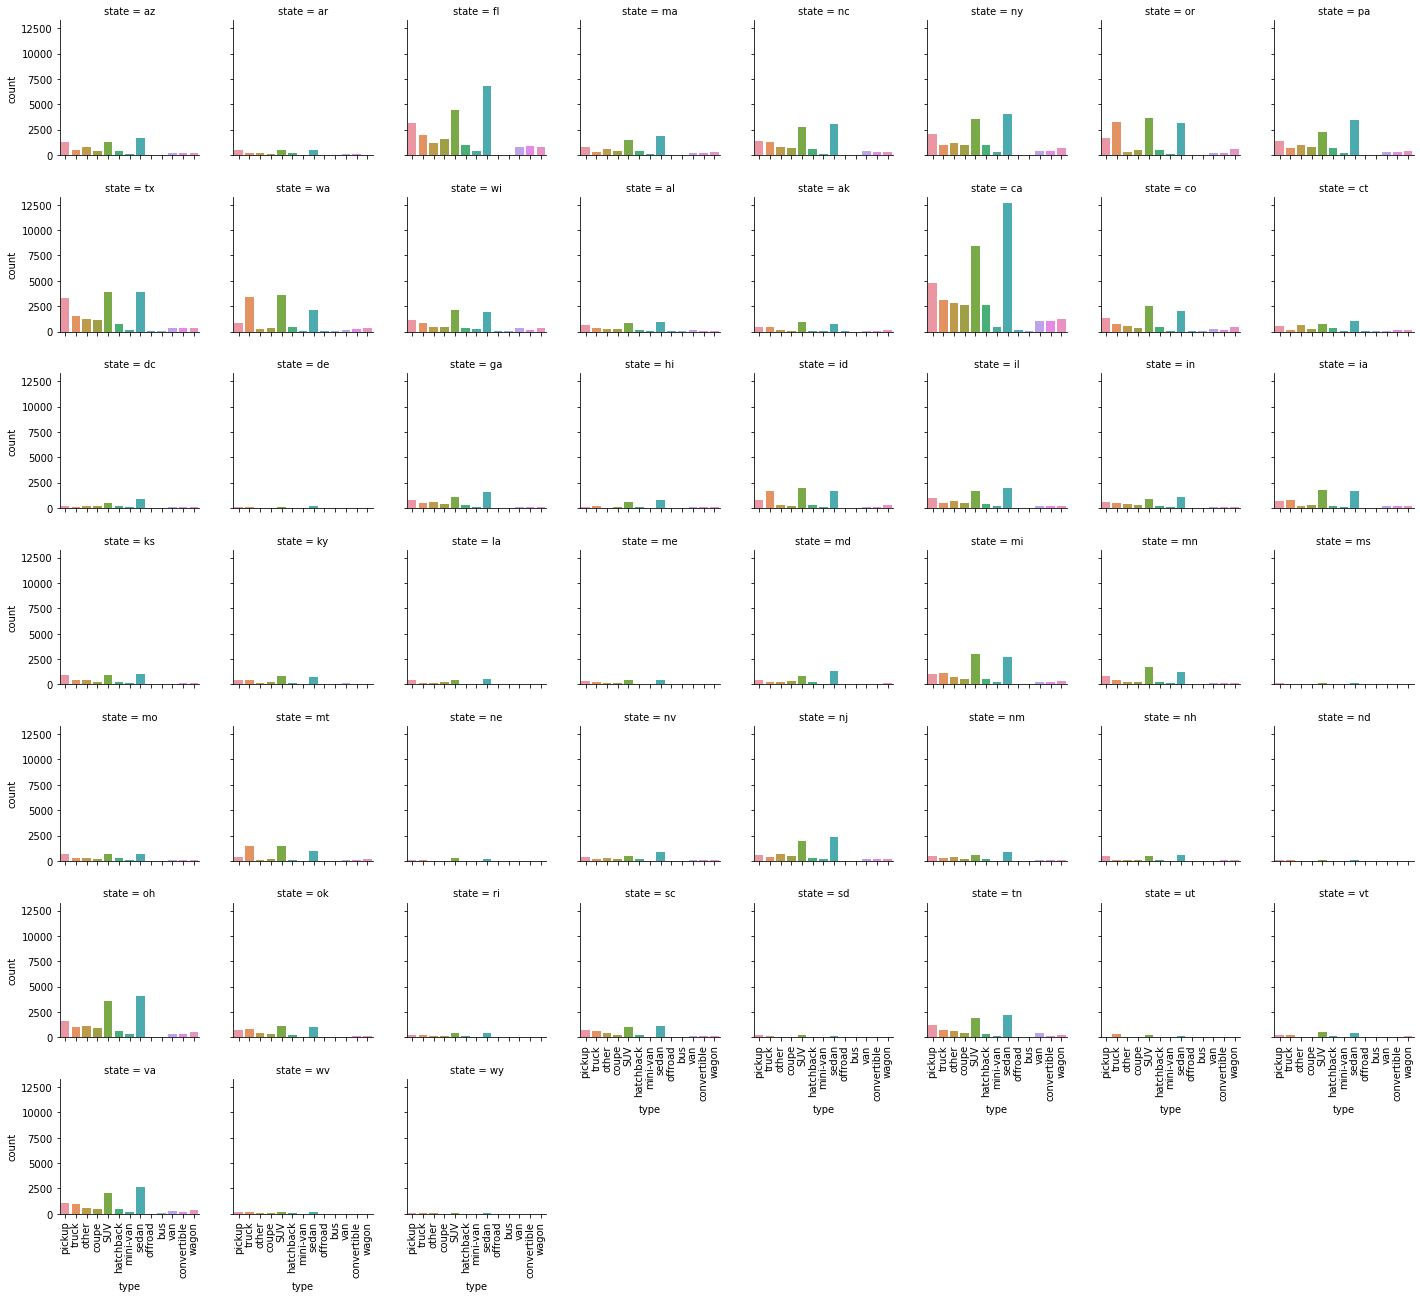

In [14]:
state_type = cleaned_data.loc[:, ['state', 'type']]
grid = sns.catplot(x = 'type', col = 'state', col_wrap = 8, data = state_type, kind = 'count', height = 2.5)
grid.set_xticklabels(rotation = "vertical")
plt.show()

# Test Model

In [15]:
def cylinder_encode(x):
  if x not in [np.nan, 'other']:
    return int(x.split()[0])
  else:
    return x

new_data = cleaned_data.copy()
cylinders = new_data.loc[~new_data['cylinders'].isin([np.nan, 'other']), 'cylinders']
cylinders = cylinders.apply(cylinder_encode)

cyl_mode = cylinders.quantile(0.5)
new_data['cylinders'] = new_data['cylinders'].apply(cylinder_encode)
new_data['cylinders'].replace(to_replace = [np.nan, 'other'], value = [cyl_mode, cyl_mode], inplace = True)

In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

X = new_data.loc[:, ['cylinders', 'odometer']].fillna(0)
y = new_data.loc[:, ['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 18)

#reg = MLPRegressor()
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("R2 square:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 square: -4.828053163530299e-05
MAE: 169219.03594952868
MSE: 327042185490624.94
